```
<Integrantes del Grupo>
<Sofia Oliverio
Ramiro Jimenez
Pablo Carrazana>
```


# Práctico 5: Aprendizaje No Supervisado

## Diversificación
Cuando se construyen carteras de inversión, se busca obtener buenos retornos mientras se limita la variabilidad de los retornos sobre el tiempo. Una forma de conseguir esto es elegir acciones que muestren diferentes "patrones de retornos". Para eso, es necesario agrupar a las acciones que tengan patrones similares en clusters y seleccionar nuestras inversiones a partir de ellos.

Una agrupación de acciones "natural" viene a partir de la Industria a la cual pertenecen, algo con lo que trabajamos en el Práctico 2 para aquellas que pertenecen al índice S&P500. Consigamos esos datos nuevamente.

In [137]:
! pip install yfinance
! pip install -U statsmodels==0.12.0

In [138]:
#Importamos librerías
import pandas as pd
import numpy as np
from pandas_datareader import data
import yfinance as yf #importe esta librería porque me permitía trabajar con los datos de yahoo.
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
import seaborn as sns
import matplotlib.ticker as plticker
import plotly.express as px

In [139]:
# código para traer la lista de acciones del S&P500

yf.pdr_override()

tickers = ['SPY']

start_date = '2000-01-01'
end_date = '2021-12-31'

data.DataReader(
    tickers,
    start=start_date, 
    end=end_date, 
    data_source='yahoo',
)["Adj Close"]

[*********************100%***********************]  1 of 1 completed


Date
2000-01-03     97.195305
2000-01-04     93.394402
2000-01-05     93.561447
2000-01-06     92.057770
2000-01-07     97.404175
                 ...    
2021-10-04    428.640015
2021-10-05    433.100006
2021-10-06    434.899994
2021-10-07    438.660004
2021-10-08    437.859985
Name: Adj Close, Length: 5478, dtype: float64

### Acciones que componen SP&500

In [140]:
# Podemos usar la función 'read_html' de Pandas, a la cual le mandamos nuestra URL y nos devuelve una lista de DataFrames que Pandas pudo rescatar desde la página.
# Vamos a usarla para obtener nuestra lista de constituyentes.
snp = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")
df = pd.DataFrame(snp[0])
df

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...,...
500,YUM,Yum! Brands,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
501,ZBRA,Zebra Technologies,reports,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
502,ZBH,Zimmer Biomet,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
503,ZION,Zions Bancorp,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


## Clustering Jerárquico

Realizar clustering para series de tiempo es un poco diferente a hacerlo con datos tabulares (no tanto, algunas técnicas sirven para ambos sin problemas), pero existen herramientas para poder realizarlo en SKLearn. En este caso, nos vamos a meter con el **clustering jerárquico**: vamos a generar *clusters anidados* al juntarlos o separarlos de manera sucesiva. La jerarquía se representa como un árbol o *dendrograma*, donde la raíz es el único cluster que junta a todas las acciones y las hojas representan a los clusters formados por una sola acción. Como siempre, una buena lectura para este tipo de conceptos puede ser [Wikipedia](https://en.wikipedia.org/wiki/Hierarchical_clustering)

<p><a href="https://commons.wikimedia.org/wiki/File:Hierarchical_clustering_simple_diagram.svg#/media/File:Hierarchical_clustering_simple_diagram.svg"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/ad/Hierarchical_clustering_simple_diagram.svg/1200px-Hierarchical_clustering_simple_diagram.svg.png" alt="Hierarchical clustering simple diagram.svg", width=300></a><br>

Es posible hacer clustering jerárquico con la función con SKLearn utilizando la función [AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html), que realiza por nosotros este proceso, a partir de clusters de una sola acción y luego los va uniendo a partir de alguna función de *linkage*, que es algún tipo de distancia entre ellos.

Nuestro primer objetivo va a ser intentar recuperar las industrias a las cuales pertenecen las acciones basándonos sólo en sus patrones de **retornos**:

- Elijamos 4 sectores del S&P500 y consigamos los precios de sus acciones (o algunas de ellas si son muchas) durante todo el 2020.
- Obtengamos los retornos diarios de las acciones y apliquemos la función de clustering a ellos.
- Generemos la visualización del dendrograma (se puede seguir el [siguiente tutorial](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py))
- Veamos si coinciden algunas de las posibles agrupaciones de acciones con las industrias a las que pertenecen y saquemos algunas conclusiones. Se puede utilizar diferentes funciones de *linkage* para ver si alguna consigue mejores agrupaciones.
    

In [141]:
# Generar una copia del df original
snp_copy=df.copy()

# Visualizar los sectores disponibles
list_seccion = snp_copy['GICS Sector'].unique().tolist()

# Imprimir la lista de los sectores disponibles
print("Lista de sectores disponibles:", list_seccion)

# Imprimir la cantidad de secciones existentes
print("Cantidad de secciones:", len(list_seccion))

# Imprimir la cantidad de secciones por sector
# En base a estas cantidades elegimos los sectores

result = snp_copy.groupby('GICS Sector')['Symbol'].nunique()
print("Cantidad de acciones por sector del S&P500:", result)

Lista de sectores disponibles: ['Industrials', 'Health Care', 'Information Technology', 'Communication Services', 'Consumer Discretionary', 'Utilities', 'Financials', 'Materials', 'Real Estate', 'Consumer Staples', 'Energy']
Cantidad de secciones: 11
Cantidad de acciones por sector del S&P500: GICS Sector
Communication Services    27
Consumer Discretionary    63
Consumer Staples          32
Energy                    21
Financials                65
Health Care               64
Industrials               74
Information Technology    74
Materials                 28
Real Estate               29
Utilities                 28
Name: Symbol, dtype: int64


#### Selección de sectores
Al visualizar que los sectores que más repeticiones tienen son:

* Information Technology: 74
* Financials: 65
* Health Care: 64

Se eligen los mismos para realizar el análisis.

In [142]:
# Filtrar por los sectores elegidos
# Los sectores elgidos: Information Technology, Financials, Health Care
result_sector = snp_copy[snp_copy['GICS Sector'].isin(['Health Care','Information Technology','Financials']) ]

# Imrpimir el resultado obtenido de filtrar los sectores elegidos
result_sector

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
6,ADBE,Adobe,reports,Information Technology,Application Software,"San Jose, California",1997-05-05,796343,1982
...,...,...,...,...,...,...,...,...,...
498,XLNX,Xilinx,reports,Information Technology,Semiconductors,"San Jose, California",1999-11-08,743988,1984
501,ZBRA,Zebra Technologies,reports,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
502,ZBH,Zimmer Biomet,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
503,ZION,Zions Bancorp,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


#### Dataframe con sectores elegidos

In [143]:
#Buscamos tickers que pertenecen a los sectores elegidos
tickers_snp = result_sector['Symbol'].tolist()

# Definimos el rango de fechas deseado
start_date = '2020-01-02'
end_date = '2020-12-31'

# Obtenemos un DataFrame
df_tickers = data.DataReader(
    tickers_snp,
    start=start_date, 
    end=end_date, 
    data_source='yahoo',
)

[*********************100%***********************]  203 of 203 completed

2 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- OGN: Data doesn't exist for startDate = 1577923200, endDate = 1609372800


In [144]:
#Cambiar filas por columnas para poder realizar el join con el dataframe result_sector
df_tr= df_tickers['Adj Close'].transpose()

#Crear nuevo dataframe donde se agregan los Precios cerrados ajustados de los tickers
df_join = result_sector.join(df_tr.reindex(df_tr.index, level=0),on = 'Symbol')

# Imprimir las primeras 5 filas del nuevo dataframe
df_join[:5]

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded,2020-01-02 00:00:00,2020-01-03 00:00:00,2020-01-06 00:00:00,2020-01-07 00:00:00,2020-01-08 00:00:00,2020-01-09 00:00:00,2020-01-10 00:00:00,2020-01-13 00:00:00,2020-01-14 00:00:00,2020-01-15 00:00:00,2020-01-16 00:00:00,2020-01-17 00:00:00,2020-01-21 00:00:00,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,...,2020-11-03 00:00:00,2020-11-04 00:00:00,2020-11-05 00:00:00,2020-11-06 00:00:00,2020-11-09 00:00:00,2020-11-10 00:00:00,2020-11-11 00:00:00,2020-11-12 00:00:00,2020-11-13 00:00:00,2020-11-16 00:00:00,2020-11-17 00:00:00,2020-11-18 00:00:00,2020-11-19 00:00:00,2020-11-20 00:00:00,2020-11-23 00:00:00,2020-11-24 00:00:00,2020-11-25 00:00:00,2020-11-27 00:00:00,2020-11-30 00:00:00,2020-12-01 00:00:00,2020-12-02 00:00:00,2020-12-03 00:00:00,2020-12-04 00:00:00,2020-12-07 00:00:00,2020-12-08 00:00:00,2020-12-09 00:00:00,2020-12-10 00:00:00,2020-12-11 00:00:00,2020-12-14 00:00:00,2020-12-15 00:00:00,2020-12-16 00:00:00,2020-12-17 00:00:00,2020-12-18 00:00:00,2020-12-21 00:00:00,2020-12-22 00:00:00,2020-12-23 00:00:00,2020-12-24 00:00:00,2020-12-28 00:00:00,2020-12-29 00:00:00,2020-12-30 00:00:00
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888,84.622925,83.591309,84.029243,83.562103,83.902733,84.126579,83.075478,82.841911,83.799713,85.402611,86.282249,86.985947,87.699432,89.781250,88.676811,88.354279,87.562599,87.513741,87.122780,87.142349,85.168045,85.089851,86.233383,87.533272,87.445320,85.881531,86.301796,87.152107,86.780708,86.673187,87.631020,...,108.308861,110.256371,112.233528,113.113365,108.140800,109.544586,111.363579,110.671570,111.314148,112.371925,111.768890,108.516464,109.732422,109.623680,108.022179,106.381142,105.194847,106.391022,106.984177,107.251083,106.914970,106.302048,106.667824,105.956047,105.580391,105.105865,105.303574,105.797867,105.570503,106.222961,106.114212,107.537766,107.725601,106.855644,107.043480,106.222961,107.112679,106.559082,107.092911,107.201660
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888),81.950546,81.172668,81.813263,81.346550,81.923080,82.554527,81.502121,81.007950,81.805595,82.788757,82.788757,81.620110,81.610817,80.887367,79.088020,77.483437,77.928642,77.696762,77.168098,75.851036,75.146141,76.333351,78.244003,80.349419,80.859558,85.599083,87.880737,89.040108,90.700348,88.437233,87.231483,...,84.951645,91.267975,90.485680,89.674400,91.866768,95.488518,94.793144,94.261955,95.652710,94.995956,95.816887,95.343643,96.261154,97.391129,98.685310,100.404419,100.636223,101.302620,101.003227,100.481689,101.399200,101.157745,103.610886,102.220131,104.006851,104.953331,103.813698,102.703018,100.636223,99.303421,101.061172,101.302620,100.877670,100.162979,99.284103,99.747688,99.728371,99.911865,101.119118,101.669624
3,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981,168.809998,166.820007,179.039993,180.350006,178.690002,183.600006,189.059998,168.100006,172.729996,177.919998,181.440002,181.279999,189.910004,184.419998,184.460007,182.979996,181.449997,187.009995,188.850006,186.850006,186.289993,185.949997,190.899994,190.729996,196.009995,186.910004,174.080002,175.820007,166.940002,164.800003,167.220001,...,260.799988,266.440002,272.399994,272.209991,279.609985,268.839996,269.279999,268.290009,272.100006,272.750000,269.929993,266.209991,270.609985,268.209991,266.429993,265.670013,263.820007,271.899994,274.100006,268.209991,265.250000,266.839996,272.609985,271.880005,273.640015,266.149994,267.929993,258.45001

In [145]:
# Elimino las primeras columnas para calcular los retornos
df_join_filter = df_join.iloc[:, 9:]
df_join_filter

,2020-01-02,2020-01-03,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,...,2020-11-03,2020-11-04,2020-11-05,2020-11-06,2020-11-09,2020-11-10,2020-11-11,2020-11-12,2020-11-13,2020-11-16,2020-11-17,2020-11-18,2020-11-19,2020-11-20,2020-11-23,2020-11-24,2020-11-25,2020-11-27,2020-11-30,2020-12-01,2020-12-02,2020-12-03,2020-12-04,2020-12-07,2020-12-08,2020-12-09,2020-12-10,2020-12-11,2020-12-14,2020-12-15,2020-12-16,2020-12-17,2020-12-18,2020-12-21,2020-12-22,2020-12-23,2020-12-24,2020-12-28,2020-12-29,2020-12-30
1,84.622925,83.591309,84.029243,83.562103,83.902733,84.126579,83.075478,82.841911,83.799713,85.402611,86.282249,86.985947,87.699432,89.781250,88.676811,88.354279,87.562599,87.513741,87.122780,87.142349,85.168045,85.089851,86.233383,87.533272,87.445320,85.881531,86.301796,87.152107,86.780708,86.673187,87.631020,86.868668,87.337814,86.458183,85.471031,82.714836,79.294060,79.518837,77.397949,75.286827,...,108.308861,110.256371,112.233528,113.113365,108.140800,109.544586,111.363579,110.671570,111.314148,112.371925,111.768890,108.516464,109.732422,109.623680,108.022179,106.381142,105.194847,106.391022,106.984177,107.251083,106.914970,106.302048,106.667824,105.956047,105.580391,105.105865,105.303574,105.797867,105.570503,106.222961,106.114212,107.537766,107.725601,106.855644,107.043480,106.222961,107.112679,106.559082,107.092911,107.201660
2,81.950546,81.172668,81.813263,81.346550,81.923080,82.554527,81.502121,81.007950,81.805595,82.788757,82.788757,81.620110,81.610817,80.887367,79.088020,77.483437,77.928642,77.696762,77.168098,75.851036,75.146141,76.333351,78.244003,80.349419,80.859558,85.599083,87.880737,89.040108,90.700348,88.437233,87.231483,86.823395,87.314957,87.398438,88.075508,86.387466,82.714554,82.000381,79.227150,79.496117,...,84.951645,91.267975,90.485680,89.674400,91.866768,95.488518,94.793144,94.261955,95.652710,94.995956,95.816887,95.343643,96.261154,97.391129,98.685310,100.404419,100.636223,101.302620,101.003227,100.481689,101.399200,101.157745,103.610886,102.220131,104.006851,104.953331,103.813698,102.703018,100.636223,99.303421,101.061172,101.302620,100.877670,100.162979,99.284103,99.747688,99.728371,99.911865,101.119118,101.669624
3,168.809998,166.820007,179.039993,180.350006,178.690002,183.600006,189.059998,168.100006,172.729996,177.919998,181.440002,181.279999,189.910004,184.419998,184.460007,182.979996,181.449997,187.009995,188.850006,186.850006,186.289993,185.949997,190.899994,190.729996,196.009995,186.910004,174.080002,175.820007,166.940002,164.800003,167.220001,169.000000,167.899994,168.080002,166.740005,165.289993,158.800003,154.089996,153.970001,150.259995,...,260.799988,266.440002,272.399994,272.209991,279.609985,268.839996,269.279999,268.290009,272.100006,272.750000,269.929993,266.209991,270.609985,268.209991,266.429993,265.670013,263.820007,271.899994,274.100006,268.209991,265.250000,266.839996,272.609985,271.880005,273.640015,266.149994,267.929993,258.450012,267.619995,275.359985,274.140015,281.989990,293.390015,295.809998,302.329987,304.049988,303.410004,312.910004,320.929993,323.920013
4,204.910934,204.569702,203.233810,198.846039,199.236069,201.010681,202.483047,204.364899,202.551285,202.874298,204.557907,204.773239,204.724319,204.978836,206.221939,204.156601,202.179337,205.791245,203.559494,203.960800,200.867676,203.402893,208.032791,207.729370,209.628311,207.102905,208.052383,207.651047,207.504242,207.905548,207.876205,209.236786,211.351074,209.373810,207.406342,200.035675,192.929291,191.529572,182.494873,176.768661,...,223.616104,225.805588,231.819290,234.097946,237.991486,236.495514,240.498001,235.940689,239.537018,242.677597,2

#### Cálculo de retornos

In [146]:
# Cálculo de los retornos
df_join_returns = df_join_filter.pct_change(periods=1, fill_method='pad', limit=None, freq=None, axis=1)
df_join_returns = df_join_returns.iloc[:, 1:]
df_join_returns

,2020-01-03,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-03-02,...,2020-11-03,2020-11-04,2020-11-05,2020-11-06,2020-11-09,2020-11-10,2020-11-11,2020-11-12,2020-11-13,2020-11-16,2020-11-17,2020-11-18,2020-11-19,2020-11-20,2020-11-23,2020-11-24,2020-11-25,2020-11-27,2020-11-30,2020-12-01,2020-12-02,2020-12-03,2020-12-04,2020-12-07,2020-12-08,2020-12-09,2020-12-10,2020-12-11,2020-12-14,2020-12-15,2020-12-16,2020-12-17,2020-12-18,2020-12-21,2020-12-22,2020-12-23,2020-12-24,2020-12-28,2020-12-29,2020-12-30
1,-0.012191,0.005239,-0.005559,0.004076,0.002668,-0.012494,-0.002811,0.011562,0.019128,0.010300,0.008156,0.008202,0.023738,-0.012301,-0.003637,-0.008960,-0.000558,-0.004467,0.000225,-0.022656,-0.000918,0.013439,0.015074,-0.001005,-0.017883,0.004894,0.009853,-0.004262,-0.001239,0.011051,-0.008700,0.005401,-0.010072,-0.011418,-0.032247,-0.041356,0.002835,-0.026672,-0.027276,0.059457,...,0.019352,0.017981,0.017932,0.007839,-0.043961,0.012981,0.016605,-0.006214,0.005806,0.009503,-0.005366,-0.029100,0.011205,-0.000991,-0.014609,-0.015192,-0.011151,0.011371,0.005575,0.002495,-0.003134,-0.005733,0.003441,-0.006673,-0.003545,-0.004494,0.001881,0.004694,-0.002149,0.006180,-0.001024,0.013415,0.001747,-0.008076,0.001758,-0.007665,0.008376,-0.005168,0.005010,0.001015
2,-0.009492,0.007892,-0.005705,0.007087,0.007708,-0.012748,-0.006063,0.009847,0.012018,0.000000,-0.014116,-0.000114,-0.008865,-0.022245,-0.020289,0.005746,-0.002976,-0.006804,-0.017067,-0.009293,0.015799,0.025030,0.026908,0.006349,0.058614,0.026655,0.013193,0.018646,-0.024952,-0.013634,-0.004678,0.005662,0.000956,0.007747,-0.019166,-0.042517,-0.008634,-0.033820,0.003395,0.034769,...,-0.003286,0.074352,-0.008571,-0.008966,0.024448,0.039424,-0.007282,-0.005604,0.014754,-0.006866,0.008642,-0.004939,0.009623,0.011739,0.013288,0.017420,0.002309,0.006622,-0.002955,-0.005164,0.009131,-0.002381,0.024251,-0.013423,0.017479,0.009100,-0.010858,-0.010699,-0.020124,-0.013244,0.017701,0.002389,-0.004195,-0.007085,-0.008774,0.004669,-0.000194,0.001840,0.012083,0.005444
3,-0.011788,0.073253,0.007317,-0.009204,0.027478,0.029739,-0.110864,0.027543,0.030047,0.019784,-0.000882,0.047606,-0.028908,0.000217,-0.008023,-0.008362,0.030642,0.009839,-0.010590,-0.002997,-0.001825,0.026620,-0.000891,0.027683,-0.046426,-0.068643,0.009995,-0.050506,-0.012819,0.014684,0.010645,-0.006509,0.001072,-0.007972,-0.008696,-0.039264,-0.029660,-0.000779,-0.024096,0.032211,...,0.023347,0.021626,0.022369,-0.000698,0.027185,-0.038518,0.001637,-0.003676,0.014201,0.002389,-0.010339,-0.013781,0.016528,-0.008869,-0.006637,-0.002852,-0.006964,0.030627,0.008091,-0.021489,-0.011036,0.005994,0.021623,-0.002678,0.006473,-0.027372,0.006688,-0.035382,0.035481,0.028922,-0.004430,0.028635,0.040427,0.008248,0.022041,0.005689,-0.002105,0.031311,0.025630,0.009317
4,-0.001665,-0.006530,-0.021590,0.001961,0.008907,0.007325,0.009294,-0.008874,0.001595,0.008299,0.001053,-0.000239,0.001243,0.006065,-0.010015,-0.009685,0.017865,-0.010845,0.001971,-0.015165,0.012621,0.022762,-0.001459,0.009141,-0.012047,0.004585,-0.001929,-0.000707,0.001934,-0.000141,0.006545,0.010105,-0.009355,-0.009397,-0.035537,-0.035526,-0.007255,-0.047171,-0.031377,0.049615,...,0.025069,0.009791,0.026632,0.009829,0.016632,-0.006286,0.016924,-0.018949,0.015243,0.013111,-0.004613,-0.016775,0.014475,0.000987,0.011338,0.015435,-0.002680,0.003168,-0.004118,0.012766,-0.010346,0.001081,0.014044,-0.016335,0.002246,-0.012367,-0.002472,-0.001341,-0.008461,0.013538,0.001619,0.068782,0.006730,-0.018141,-0.007459,-0.007824,-0.000544,0.009250,-0.007394,-0.000854
6,-0.007834,0.005726,-0.000959,0.013438,0.007636,-0.001

#### Función de clustering

In [147]:
# Elimino Nan de df_join_returns y df_join
df_join_returns = df_join_returns.dropna()
df_join = df_join.dropna()

In [148]:
# {‘ward’, ‘complete’, ‘average’, ‘single’}
# Clustering con linkage Complete
clustering = AgglomerativeClustering(n_clusters=4, linkage= 'complete').fit(df_join_returns)
clustering

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='complete', memory=None, n_clusters=4)

In [149]:
# Agrego GICS Sector, Symbol y valores de clustering
df_join_returns['GICS Sector'] = df_join['GICS Sector']
df_join_returns['Symbol'] = df_join['Symbol']
df_join_returns['Clustering']= clustering.labels_
df_join_returns

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

,2020-01-03 00:00:00,2020-01-06 00:00:00,2020-01-07 00:00:00,2020-01-08 00:00:00,2020-01-09 00:00:00,2020-01-10 00:00:00,2020-01-13 00:00:00,2020-01-14 00:00:00,2020-01-15 00:00:00,2020-01-16 00:00:00,2020-01-17 00:00:00,2020-01-21 00:00:00,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-03-02 00:00:00,...,2020-11-06 00:00:00,2020-11-09 00:00:00,2020-11-10 00:00:00,2020-11-11 00:00:00,2020-11-12 00:00:00,2020-11-13 00:00:00,2020-11-16 00:00:00,2020-11-17 00:00:00,2020-11-18 00:00:00,2020-11-19 00:00:00,2020-11-20 00:00:00,2020-11-23 00:00:00,2020-11-24 00:00:00,2020-11-25 00:00:00,2020-11-27 00:00:00,2020-11-30 00:00:00,2020-12-01 00:00:00,2020-12-02 00:00:00,2020-12-03 00:00:00,2020-12-04 00:00:00,2020-12-07 00:00:00,2020-12-08 00:00:00,2020-12-09 00:00:00,2020-12-10 00:00:00,2020-12-11 00:00:00,2020-12-14 00:00:00,2020-12-15 00:00:00,2020-12-16 00:00:00,2020-12-17 00:00:00,2020-12-18 00:00:00,2020-12-21 00:00:00,2020-12-22 00:00:00,2020-12-23 00:00:00,2020-12-24 00:00:00,2020-12-28 00:00:00,2020-12-29 00:00:00,2020-12-30 00:00:00,GICS Sector,Symbol,Clustering
1,-0.012191,0.005239,-0.005559,0.004076,0.002668,-0.012494,-0.002811,0.011562,0.019128,0.010300,0.008156,0.008202,0.023738,-0.012301,-0.003637,-0.008960,-0.000558,-0.004467,0.000225,-0.022656,-0.000918,0.013439,0.015074,-0.001005,-0.017883,0.004894,0.009853,-0.004262,-0.001239,0.011051,-0.008700,0.005401,-0.010072,-0.011418,-0.032247,-0.041356,0.002835,-0.026672,-0.027276,0.059457,...,0.007839,-0.043961,0.012981,0.016605,-0.006214,0.005806,0.009503,-0.005366,-0.029100,0.011205,-0.000991,-0.014609,-0.015192,-0.011151,0.011371,0.005575,0.002495,-0.003134,-0.005733,0.003441,-0.006673,-0.003545,-0.004494,0.001881,0.004694,-0.002149,0.006180,-0.001024,0.013415,0.001747,-0.008076,0.001758,-0.007665,0.008376,-0.005168,0.005010,0.001015,Health Care,ABT,1
2,-0.009492,0.007892,-0.005705,0.007087,0.007708,-0.012748,-0.006063,0.009847,0.012018,0.000000,-0.014116,-0.000114,-0.008865,-0.022245,-0.020289,0.005746,-0.002976,-0.006804,-0.017067,-0.009293,0.015799,0.025030,0.026908,0.006349,0.058614,0.026655,0.013193,0.018646,-0.024952,-0.013634,-0.004678,0.005662,0.000956,0.007747,-0.019166,-0.042517,-0.008634,-0.033820,0.003395,0.034769,...,-0.008966,0.024448,0.039424,-0.007282,-0.005604,0.014754,-0.006866,0.008642,-0.004939,0.009623,0.011739,0.013288,0.017420,0.002309,0.006622,-0.002955,-0.005164,0.009131,-0.002381,0.024251,-0.013423,0.017479,0.009100,-0.010858,-0.010699,-0.020124,-0.013244,0.017701,0.002389,-0.004195,-0.007085,-0.008774,0.004669,-0.000194,0.001840,0.012083,0.005444,Health Care,ABBV,1
3,-0.011788,0.073253,0.007317,-0.009204,0.027478,0.029739,-0.110864,0.027543,0.030047,0.019784,-0.000882,0.047606,-0.028908,0.000217,-0.008023,-0.008362,0.030642,0.009839,-0.010590,-0.002997,-0.001825,0.026620,-0.000891,0.027683,-0.046426,-0.068643,0.009995,-0.050506,-0.012819,0.014684,0.010645,-0.006509,0.001072,-0.007972,-0.008696,-0.039264,-0.029660,-0.000779,-0.024096,0.032211,...,-0.000698,0.027185,-0.038518,0.001637,-0.003676,0.014201,0.002389,-0.010339,-0.013781,0.016528,-0.008869,-0.006637,-0.002852,-0.006964,0.030627,0.008091,-0.021489,-0.011036,0.005994,0.021623,-0.002678,0.006473,-0.027372,0.006688,-0.035382,0.035481,0.028922,-0.004430,0.028635,0.040427,0.008248,0.022041,0.005689,-0.002105,0.031311,0.025630,0.009317,Health Care,ABMD,1
4,-0.001665,-0.006530,-0.021590,0.001961,0.008907,0.007325,0.009294,-0.008874,0.001595,0.008299,0.001053,-0.000239,0.001243,0.006065,-0.010015,-0.009685,0.01

#### Dendograma

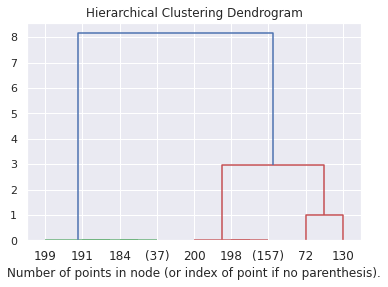

In [150]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(df_join_returns[['Clustering']])

plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

#### Coincidencias

* WARD --> A finanlicals le asocia (0,1,2)
* COMPLETE --> A financials le asocia (0,1) muy variado 
* AVERAGE --> A financials le asocia (0,1) pero mayor cantidad de 0 que de 1

Podemos observar a simple vista que para Financials utilizó diferentes valores de agrupación

## Probemos los clusters!

Una vez que se haya podido realizar el clustering y estemos "conformes", elijamos un nivel de linkage que nos permita tener 4 clusters y construyamos la siguiente estrategia de inversión:
- Elegir una acción de cada cluster aleatoriamente
- Invertir el 25% del dinero en cada una de ellas
- La estrategia corre durante todo 2021 hasta finales de agosto
- Comenzar con $10.000

Grafiquemos el avance de la misma, junto al avance del S&P500 y calculemos el Sharpe Ratio de cada una de ellas.

#### Búsqueda de Tickers 2021

In [151]:
#Buscamos tickers que pertenecen a los sectores elegidos
tickers_snp = result_sector['Symbol'].tolist()

# Definimos el rango de fechas deseado
start_date = '2021-01-02'
end_date = '2021-12-31'

# Obtenemos un DataFrame
df_tickers_2021 = data.DataReader(
    tickers_snp,
    start=start_date, 
    end=end_date, 
    data_source='yahoo',
)

[*********************100%***********************]  203 of 203 completed

1 Failed download:
- BRK.B: No data found, symbol may be delisted


#### Búsqueda de Tickers SP500

In [152]:
# Agregar SP&500
tickers = ['SPY']

#Se filtran datos de S&P500 desde 2000
start_date= '2021-01-01'
end_date= '2021-12-31'

dfP500 = data.DataReader(
    tickers,
    start=start_date, 
    end=end_date, 
    data_source='yahoo',
)["Adj Close"].to_frame()

[*********************100%***********************]  1 of 1 completed


#### Dataframe Tickers 2021

In [153]:
#Cambiar filas por columnas para poder realizar el join con el dataframe result_sector
df_tr= df_tickers_2021['Adj Close'].transpose()

#Crear nuevo dataframe donde se agregan los Precios cerrados ajustados de los tickers
df_join_2021 = result_sector.join(df_tr.reindex(df_tr.index, level=0),on = 'Symbol')

# Elimino las primeras columnas para calcular los retornos
df_join_filter_2021 = df_join_2021.iloc[:, 9:]

# Cálculo de los retornos
df_join_returns_2021 = df_join_filter_2021.pct_change(periods=1, fill_method='pad', limit=None, freq=None, axis=1)
df_join_returns_2021 = df_join_returns_2021.iloc[:, 1:]

# Elimino Nan de df_join_returns y df_join
df_join_returns_2021 = df_join_returns_2021.dropna()
df_join_2021 = df_join_2021.dropna()

# Visualizar el dataframe de retornos
df_join_returns_2021

,2021-01-05,2021-01-06,2021-01-07,2021-01-08,2021-01-11,2021-01-12,2021-01-13,2021-01-14,2021-01-15,2021-01-19,2021-01-20,2021-01-21,2021-01-22,2021-01-25,2021-01-26,2021-01-27,2021-01-28,2021-01-29,2021-02-01,2021-02-02,2021-02-03,2021-02-04,2021-02-05,2021-02-08,2021-02-09,2021-02-10,2021-02-11,2021-02-12,2021-02-16,2021-02-17,2021-02-18,2021-02-19,2021-02-22,2021-02-23,2021-02-24,2021-02-25,2021-02-26,2021-03-01,2021-03-02,2021-03-03,...,2021-08-13,2021-08-16,2021-08-17,2021-08-18,2021-08-19,2021-08-20,2021-08-23,2021-08-24,2021-08-25,2021-08-26,2021-08-27,2021-08-30,2021-08-31,2021-09-01,2021-09-02,2021-09-03,2021-09-07,2021-09-08,2021-09-09,2021-09-10,2021-09-13,2021-09-14,2021-09-15,2021-09-16,2021-09-17,2021-09-20,2021-09-21,2021-09-22,2021-09-23,2021-09-24,2021-09-27,2021-09-28,2021-09-29,2021-09-30,2021-10-01,2021-10-04,2021-10-05,2021-10-06,2021-10-07,2021-10-08
1,0.012373,-0.002082,0.009707,0.002785,-0.006899,-0.018044,0.030412,-0.014861,0.011450,0.011411,0.002843,0.000532,-0.000974,0.016661,0.000087,-0.003835,0.053373,0.026580,-0.008496,-0.018769,-0.000166,-0.003993,0.035828,0.003789,0.005221,0.001119,0.012371,0.010959,-0.001638,-0.006093,-0.014382,-0.018898,-0.003982,-0.014280,0.013079,-0.006537,-0.014805,0.020287,0.002618,-0.027340,...,0.002036,0.013002,0.008262,-0.014003,0.014444,0.004772,-0.003800,-0.002702,-0.006056,0.005852,-0.007014,0.010836,0.003414,0.008151,0.008556,0.003502,-0.004266,0.005218,-0.008368,0.006407,-0.016925,0.003396,0.003463,-0.000392,-0.005100,-0.015143,0.002082,-0.003836,0.005215,-0.007422,-0.030474,-0.015260,0.006064,-0.011133,-0.007788,-0.014333,0.003030,0.005264,0.012190,0.004071
2,0.010341,-0.008639,0.010703,0.005248,0.016314,0.006971,0.024321,0.004318,-0.009944,0.015020,0.003922,-0.012076,-0.003595,-0.003247,-0.015385,-0.055239,0.013815,-0.016601,-0.001756,0.011437,0.033633,0.014773,0.001843,-0.017383,-0.013478,-0.012808,-0.002883,0.006651,-0.002298,0.020058,-0.002164,-0.009900,0.019522,-0.007379,0.022772,-0.012513,0.003820,0.006219,-0.005166,-0.010570,...,0.007264,0.016569,0.010557,-0.019806,0.005457,0.007547,0.004545,0.002681,0.006016,0.000000,-0.006811,0.008279,0.001742,-0.070459,-0.002227,-0.003571,-0.023204,0.012198,-0.027999,-0.005500,0.007499,-0.009304,0.012115,0.002877,-0.003238,-0.012346,0.007049,-0.006906,0.008928,-0.002701,0.006071,-0.003528,0.013974,-0.008912,0.011310,-0.003300,0.007174,-0.001735,0.014179,0.002796
3,0.018533,-0.003069,0.006063,0.001545,0.001635,0.000247,-0.002957,-0.016682,0.035751,0.020049,0.034404,0.001984,-0.001894,0.001207,-0.021331,-0.036053,0.080736,-0.019373,-0.018349,0.017493,-0.062126,-0.004445,0.009453,-0.006070,-0.004235,0.000092,-0.004869,0.016815,-0.016994,-0.020076,0.018274,0.030707,-0.027774,-0.003284,0.006497,-0.010223,0.012731,-0.000893,0.003238,-0.054440,...,-0.001614,0.007088,0.014293,0.006818,0.007709,0.044278,0.010629,0.016515,0.001091,0.001397,0.000056,0.006778,0.008311,-0.001896,0.018058,0.007733,0.009418,-0.003748,-0.023880,-0.012683,-0.025471,0.004347,0.004667,0.007574,-0.008020,-0.021465,-0.006880,0.011508,0.004728,-0.000713,-0.033936,-0.021272,-0.005313,-0.012109,-0.006728,-0.029258,0.059260,0.014528,0.008894,-0.009315
4,0.005693,0.010934,0.009435,0.003647,-0.014423,-0.007490,-0.001709,-0.008091,-0.005294,0.008634,0.022788,-0.014255,-0.012290,-0.010716,0.003769,-0.027234,0.013165,-0.029759,0.023355,0.004766,-0.001528,0.018682,0.002095,0.014870,0.001438,-0.002872,0.007901,-0.005792,-0.001631,0.006730,-0.004444,-0.012964,-0.006528,0.014092,0.012022,-0.021175,-0.011348,0.028936,0.004145,-0.019481,...,0.005252,0.014840,0.003199,-0.014425,0.011400,0.013404,0.000812,-0.006038,0.007646,-0.000630,0.007292,0.003992,-0.001306,0.003981,0.009174,0.006833,-0.005359,-0.003426,0.002292,0.002404,-0.007253,0.003771,0.010889,-0.006387,-0.019957,-0.009272,-0.003431,0.010599,0.024921,-0.010991,-0.013914,-0.030791,-0.002097,-0.011158,0.015441,-0.016530,0.017622,0.000215,0.003260,-0.003249
6,0.000721,-0.039902,0.024512,0.015406,-0.022387,-0.005461,0.0

#### Clustering

In [154]:
# {‘ward’, ‘complete’, ‘average’, ‘single’}
# Función de clustering con linkage = complete
clustering = AgglomerativeClustering(n_clusters=4, linkage= 'complete').fit(df_join_returns_2021)
clustering

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='complete', memory=None, n_clusters=4)

In [155]:
# Agrego GICS Sector, Symbol y valores de clustering
df_join_returns_2021['GICS Sector'] = df_join['GICS Sector']
df_join_returns_2021['Symbol'] = df_join['Symbol']
df_join_returns_2021['Clustering']= clustering.labels_
df_join_returns_2021

,2021-01-05 00:00:00,2021-01-06 00:00:00,2021-01-07 00:00:00,2021-01-08 00:00:00,2021-01-11 00:00:00,2021-01-12 00:00:00,2021-01-13 00:00:00,2021-01-14 00:00:00,2021-01-15 00:00:00,2021-01-19 00:00:00,2021-01-20 00:00:00,2021-01-21 00:00:00,2021-01-22 00:00:00,2021-01-25 00:00:00,2021-01-26 00:00:00,2021-01-27 00:00:00,2021-01-28 00:00:00,2021-01-29 00:00:00,2021-02-01 00:00:00,2021-02-02 00:00:00,2021-02-03 00:00:00,2021-02-04 00:00:00,2021-02-05 00:00:00,2021-02-08 00:00:00,2021-02-09 00:00:00,2021-02-10 00:00:00,2021-02-11 00:00:00,2021-02-12 00:00:00,2021-02-16 00:00:00,2021-02-17 00:00:00,2021-02-18 00:00:00,2021-02-19 00:00:00,2021-02-22 00:00:00,2021-02-23 00:00:00,2021-02-24 00:00:00,2021-02-25 00:00:00,2021-02-26 00:00:00,2021-03-01 00:00:00,2021-03-02 00:00:00,2021-03-03 00:00:00,...,2021-08-18 00:00:00,2021-08-19 00:00:00,2021-08-20 00:00:00,2021-08-23 00:00:00,2021-08-24 00:00:00,2021-08-25 00:00:00,2021-08-26 00:00:00,2021-08-27 00:00:00,2021-08-30 00:00:00,2021-08-31 00:00:00,2021-09-01 00:00:00,2021-09-02 00:00:00,2021-09-03 00:00:00,2021-09-07 00:00:00,2021-09-08 00:00:00,2021-09-09 00:00:00,2021-09-10 00:00:00,2021-09-13 00:00:00,2021-09-14 00:00:00,2021-09-15 00:00:00,2021-09-16 00:00:00,2021-09-17 00:00:00,2021-09-20 00:00:00,2021-09-21 00:00:00,2021-09-22 00:00:00,2021-09-23 00:00:00,2021-09-24 00:00:00,2021-09-27 00:00:00,2021-09-28 00:00:00,2021-09-29 00:00:00,2021-09-30 00:00:00,2021-10-01 00:00:00,2021-10-04 00:00:00,2021-10-05 00:00:00,2021-10-06 00:00:00,2021-10-07 00:00:00,2021-10-08 00:00:00,GICS Sector,Symbol,Clustering
1,0.012373,-0.002082,0.009707,0.002785,-0.006899,-0.018044,0.030412,-0.014861,0.011450,0.011411,0.002843,0.000532,-0.000974,0.016661,0.000087,-0.003835,0.053373,0.026580,-0.008496,-0.018769,-0.000166,-0.003993,0.035828,0.003789,0.005221,0.001119,0.012371,0.010959,-0.001638,-0.006093,-0.014382,-0.018898,-0.003982,-0.014280,0.013079,-0.006537,-0.014805,0.020287,0.002618,-0.027340,...,-0.014003,0.014444,0.004772,-0.003800,-0.002702,-0.006056,0.005852,-0.007014,0.010836,0.003414,0.008151,0.008556,0.003502,-0.004266,0.005218,-0.008368,0.006407,-0.016925,0.003396,0.003463,-0.000392,-0.005100,-0.015143,0.002082,-0.003836,0.005215,-0.007422,-0.030474,-0.015260,0.006064,-0.011133,-0.007788,-0.014333,0.003030,0.005264,0.012190,0.004071,Health Care,ABT,0
2,0.010341,-0.008639,0.010703,0.005248,0.016314,0.006971,0.024321,0.004318,-0.009944,0.015020,0.003922,-0.012076,-0.003595,-0.003247,-0.015385,-0.055239,0.013815,-0.016601,-0.001756,0.011437,0.033633,0.014773,0.001843,-0.017383,-0.013478,-0.012808,-0.002883,0.006651,-0.002298,0.020058,-0.002164,-0.009900,0.019522,-0.007379,0.022772,-0.012513,0.003820,0.006219,-0.005166,-0.010570,...,-0.019806,0.005457,0.007547,0.004545,0.002681,0.006016,0.000000,-0.006811,0.008279,0.001742,-0.070459,-0.002227,-0.003571,-0.023204,0.012198,-0.027999,-0.005500,0.007499,-0.009304,0.012115,0.002877,-0.003238,-0.012346,0.007049,-0.006906,0.008928,-0.002701,0.006071,-0.003528,0.013974,-0.008912,0.011310,-0.003300,0.007174,-0.001735,0.014179,0.002796,Health Care,ABBV,0
3,0.018533,-0.003069,0.006063,0.001545,0.001635,0.000247,-0.002957,-0.016682,0.035751,0.020049,0.034404,0.001984,-0.001894,0.001207,-0.021331,-0.036053,0.080736,-0.019373,-0.018349,0.017493,-0.062126,-0.004445,0.009453,-0.006070,-0.004235,0.000092,-0.004869,0.016815,-0.016994,-0.020076,0.018274,0.030707,-0.027774,-0.003284,0.006497,-0.010223,0.012731,-0.000893,0.003238,-0.054440,...,0.006818,0.007709,0.044278,0.010629,0.016515,0.001091,0.001397,0.000056,0.006778,0.008311,-0.001896,0.018058,0.007733,0.009418,-0.003748,-0.023880,-0.012683,-0.025471,0.004347,0.004667,0.007574,-0.008020,-0.021465,-0.006880,0.011508,0.004728,-0.000713,-0.033936,-0.021272,-0.005313,-0.012109,-0.006728,-0.029258,0.059260,0.014528,0.008894,-0.009315,Health Care,ABMD,0
4,0.005693,0.010934,0.009435,0.003647,-0.014423,-0.007490,-0.001709,-0.008091,-0.005294,0.008634,0.022788,-0.014255,-0.012290,-0.010716,0.003769,-0.027234,0.01316

In [156]:
# Un valor del clustering 0 
clustering_0 = df_join_returns_2021[df_join_returns_2021['Clustering'] == 0]
Symbol_clustering_0 = clustering_0.sample(n=1)

# Un valor del clustering 1
clustering_1 = df_join_returns_2021[df_join_returns_2021['Clustering'] == 1]
Symbol_clustering_1 = clustering_1.sample(n=1)

# Un valor del clustering 2
clustering_2 = df_join_returns_2021[df_join_returns_2021['Clustering'] == 2]
Symbol_clustering_2 = clustering_2.sample(n=1)

# Un valor del clustering 3
clustering_3 = df_join_returns_2021[df_join_returns_2021['Clustering'] == 3]
Symbol_clustering_3 = clustering_3.sample(n=1)

#### Cálculo de retornos SP&500

In [157]:
# Cálculo de los retornos
dfP500 = dfP500.pct_change(periods=1, fill_method='pad', limit=None, freq=None)


In [158]:
# Transpose de los retornos dfp500
dfP500_trans = dfP500.transpose()

# Elimino la posición 1 que tiene valores en NaN
dfP500_trans = dfP500_trans.iloc[:, 1:]

# Asigno el valor del Symbol
dfP500_trans['Symbol']='SP&500'

# Retornos de SP&500
dfP500_trans

Date,2021-01-05 00:00:00,2021-01-06 00:00:00,2021-01-07 00:00:00,2021-01-08 00:00:00,2021-01-11 00:00:00,2021-01-12 00:00:00,2021-01-13 00:00:00,2021-01-14 00:00:00,2021-01-15 00:00:00,2021-01-19 00:00:00,2021-01-20 00:00:00,2021-01-21 00:00:00,2021-01-22 00:00:00,2021-01-25 00:00:00,2021-01-26 00:00:00,2021-01-27 00:00:00,2021-01-28 00:00:00,2021-01-29 00:00:00,2021-02-01 00:00:00,2021-02-02 00:00:00,2021-02-03 00:00:00,2021-02-04 00:00:00,2021-02-05 00:00:00,2021-02-08 00:00:00,2021-02-09 00:00:00,2021-02-10 00:00:00,2021-02-11 00:00:00,2021-02-12 00:00:00,2021-02-16 00:00:00,2021-02-17 00:00:00,2021-02-18 00:00:00,2021-02-19 00:00:00,2021-02-22 00:00:00,2021-02-23 00:00:00,2021-02-24 00:00:00,2021-02-25 00:00:00,2021-02-26 00:00:00,2021-03-01 00:00:00,2021-03-02 00:00:00,2021-03-03 00:00:00,...,2021-08-16 00:00:00,2021-08-17 00:00:00,2021-08-18 00:00:00,2021-08-19 00:00:00,2021-08-20 00:00:00,2021-08-23 00:00:00,2021-08-24 00:00:00,2021-08-25 00:00:00,2021-08-26 00:00:00,2021-08-27 00:00:00,2021-08-30 00:00:00,2021-08-31 00:00:00,2021-09-01 00:00:00,2021-09-02 00:00:00,2021-09-03 00:00:00,2021-09-07 00:00:00,2021-09-08 00:00:00,2021-09-09 00:00:00,2021-09-10 00:00:00,2021-09-13 00:00:00,2021-09-14 00:00:00,2021-09-15 00:00:00,2021-09-16 00:00:00,2021-09-17 00:00:00,2021-09-20 00:00:00,2021-09-21 00:00:00,2021-09-22 00:00:00,2021-09-23 00:00:00,2021-09-24 00:00:00,2021-09-27 00:00:00,2021-09-28 00:00:00,2021-09-29 00:00:00,2021-09-30 00:00:00,2021-10-01 00:00:00,2021-10-04 00:00:00,2021-10-05 00:00:00,2021-10-06 00:00:00,2021-10-07 00:00:00,2021-10-08 00:00:00,Symbol
Adj Close,0.006887,0.005979,0.014857,0.005698,-0.006741,0.000211,0.002693,-0.003502,-0.007293,0.007852,0.013839,0.000912,-0.003539,0.003944,-0.001561,-0.02444,0.0086,-0.02002,0.016646,0.01414,0.000786,0.011366,0.003936,0.007222,-0.000666,-0.000436,0.001615,0.00494,-0.000866,0.00023,-0.004256,-0.001766,-0.007692,0.001214,0.011019,-0.024096,-0.005153,0.02424,-0.007803,-0.013246,...,0.002355,-0.006555,-0.010945,0.001548,0.007957,0.008797,0.001587,0.002098,-0.005903,0.008941,0.004398,-0.001482,0.000531,0.003077,-0.000243,-0.003576,-0.001218,-0.00428,-0.007885,0.002559,-0.005397,0.008353,-0.001585,-0.012903,-0.016674,-0.000945,0.009755,0.01215,0.001647,-0.002861,-0.020152,0.001683,-0.012222,0.011884,-0.012896,0.010405,0.004156,0.008646,-0.001824,SP&500


#### Unión de los dataframe SP&500 y 2021 con sectores elegidos

In [159]:
# Unión de los retornos de acción del cluster 0,1,2 y 3 de los retornos del SP&500
Symbol_clustering_tot = pd.concat([Symbol_clustering_0, Symbol_clustering_1, Symbol_clustering_2, Symbol_clustering_3, dfP500_trans])

# Elimino las últimas 3 columnas que tiene datos de string para poder calcular ganancias de dinero
Symbol_clustering_tot_iloc = Symbol_clustering_tot.iloc[:,0:-3]

# Dataframe sin las últimas 3 columnas
Symbol_clustering_tot_iloc

,2021-01-05,2021-01-06,2021-01-07,2021-01-08,2021-01-11,2021-01-12,2021-01-13,2021-01-14,2021-01-15,2021-01-19,2021-01-20,2021-01-21,2021-01-22,2021-01-25,2021-01-26,2021-01-27,2021-01-28,2021-01-29,2021-02-01,2021-02-02,2021-02-03,2021-02-04,2021-02-05,2021-02-08,2021-02-09,2021-02-10,2021-02-11,2021-02-12,2021-02-16,2021-02-17,2021-02-18,2021-02-19,2021-02-22,2021-02-23,2021-02-24,2021-02-25,2021-02-26,2021-03-01,2021-03-02,2021-03-03,...,2021-08-13,2021-08-16,2021-08-17,2021-08-18,2021-08-19,2021-08-20,2021-08-23,2021-08-24,2021-08-25,2021-08-26,2021-08-27,2021-08-30,2021-08-31,2021-09-01,2021-09-02,2021-09-03,2021-09-07,2021-09-08,2021-09-09,2021-09-10,2021-09-13,2021-09-14,2021-09-15,2021-09-16,2021-09-17,2021-09-20,2021-09-21,2021-09-22,2021-09-23,2021-09-24,2021-09-27,2021-09-28,2021-09-29,2021-09-30,2021-10-01,2021-10-04,2021-10-05,2021-10-06,2021-10-07,2021-10-08
324,0.015734,-0.032275,0.063162,0.016157,0.013035,-0.002395,-0.008429,-0.005203,-0.018048,0.031880,0.013033,0.017053,-0.015551,-0.014084,-0.020622,-0.082192,0.046141,-0.034486,0.035577,0.018047,-0.022826,0.004317,-0.022008,0.025340,0.028593,-0.014295,0.029245,0.003250,0.005286,-0.019796,-0.011570,0.047542,-0.053562,-0.002683,0.043588,-0.065152,0.032902,0.038796,-0.047475,-0.042555,...,0.005429,-0.013596,-0.012780,0.011576,0.020331,0.019156,0.018922,0.000309,-0.004245,0.008174,0.015886,0.016123,-0.015926,0.002344,0.003890,0.008253,-0.009500,-0.010656,-0.007580,0.011652,-0.009392,0.012424,0.001070,0.005726,-0.002626,-0.017889,0.008289,0.030974,0.019333,0.000328,-0.016952,-0.037220,-0.010172,0.000144,-0.003301,-0.039476,0.011853,-0.005729,0.011525,-0.007370
320,-0.022823,0.064847,-0.010064,-0.020332,0.040000,0.062170,-0.003934,0.045623,-0.000540,-0.035789,0.001040,0.062650,-0.014739,0.121966,0.033537,0.025012,0.024530,0.085302,-0.090552,0.006985,0.045907,0.044917,0.016906,0.055265,-0.034735,-0.001003,0.022862,0.001635,-0.028355,-0.009914,-0.040677,0.030489,-0.087959,-0.057727,-0.035826,0.024795,0.043335,0.016730,-0.067281,-0.106192,...,-0.004190,-0.040844,0.074894,-0.007615,-0.058350,0.019839,0.075487,-0.041152,0.007419,0.006108,-0.045166,-0.030166,0.016186,0.035175,0.019798,0.047880,0.047252,-0.030913,0.078080,-0.014345,-0.066002,0.019036,0.015782,0.014248,-0.024055,-0.015626,0.025299,0.015390,0.031494,-0.053806,-0.049519,-0.060244,-0.013821,0.015730,-0.113730,-0.044710,0.019243,-0.089398,0.022948,-0.014384
171,0.053646,0.120675,0.051037,-0.029706,-0.027626,0.023850,-0.013560,0.025234,-0.087344,0.056089,-0.009340,0.063641,-0.000094,-0.044042,-0.075914,-0.044411,0.082225,-0.058790,0.021881,0.033756,0.019260,-0.003616,-0.012421,0.024172,0.011270,0.009845,-0.014797,0.037322,-0.062999,-0.021499,-0.044893,0.049215,-0.115316,0.018051,0.058400,-0.074639,0.051921,0.059014,-0.079163,-0.061564,...,-0.034696,-0.042629,-0.024233,-0.006178,0.002585,0.019031,0.037653,0.003948,-0.000058,-0.002776,0.014847,0.015944,-0.022781,0.015541,0.002607,-0.016677,-0.029953,-0.031707,-0.012364,-0.019460,0.011819,-0.013367,-0.015321,0.008101,0.026150,-0.052520,0.012136,0.025407,0.000695,-0.029434,0.009111,-0.028054,-0.015328,0.010580,0.035941,-0.066491,0.016410,0.041856,0.023766,-0.018253
68,0.014159,0.005520,0.010858,0.008385,0.059317,-0.000486,-0.002693,0.051074,-0.015876,-0.007251,-0.013000,-0.000592,-0.002517,0.022640,-0.014045,-0.024000,0.010258,0.055027,-0.014685,-0.002657,-0.052103,0.015727,-0.008602,0.014486,0.001413,0.021128,0.013855,-0.002798,0.004640,-0.009487,-0.002783,0.008880,0.022562,-0.019499,0.013115,-0.019382,-0.015797,0.001319,-0.012407,-0.012044,...,0.004608,0.003652,0.018312,-0.022642,-0.009507,0.009214,0.013724,0.008573,-0.019033,-0.001488,0.002776,0.003584,-0.015998,-0.001977,-0.007894,-0.005871,-0.019065,-0.017388,-0.066553,-0.001133,0.007105,-0.019838,0.011015,0.001604,0.001668,-0.005663,-0.009883,-0.021046,0.013411,-0.005082,-0.017449,-0.006664,0.002986,-0.009000,0.003357,-0.019793,0.007617,0.011090,0.014883,-0.006742
Adj Close,0.006887,0.005979,0.014857,0.005698,

#### Cálculo de la evolución del dinero

In [160]:
# Genero copia del Dataframe
Symbol_clustering_tot_iloc_copy= Symbol_clustering_tot_iloc.copy()

# Defino valores iniciales
cant_money = 2500
cant_stocks = 0
list_money = []

# Recorro el dataframe
for column in Symbol_clustering_tot_iloc_copy:

    # Calculo el dinero
    cant_money = (cant_money * Symbol_clustering_tot_iloc_copy[column].values ) + cant_money
    Symbol_clustering_tot_iloc_copy[column] = cant_money 
    
Symbol_clustering_tot_iloc_copy

,2021-01-05,2021-01-06,2021-01-07,2021-01-08,2021-01-11,2021-01-12,2021-01-13,2021-01-14,2021-01-15,2021-01-19,2021-01-20,2021-01-21,2021-01-22,2021-01-25,2021-01-26,2021-01-27,2021-01-28,2021-01-29,2021-02-01,2021-02-02,2021-02-03,2021-02-04,2021-02-05,2021-02-08,2021-02-09,2021-02-10,2021-02-11,2021-02-12,2021-02-16,2021-02-17,2021-02-18,2021-02-19,2021-02-22,2021-02-23,2021-02-24,2021-02-25,2021-02-26,2021-03-01,2021-03-02,2021-03-03,...,2021-08-13,2021-08-16,2021-08-17,2021-08-18,2021-08-19,2021-08-20,2021-08-23,2021-08-24,2021-08-25,2021-08-26,2021-08-27,2021-08-30,2021-08-31,2021-09-01,2021-09-02,2021-09-03,2021-09-07,2021-09-08,2021-09-09,2021-09-10,2021-09-13,2021-09-14,2021-09-15,2021-09-16,2021-09-17,2021-09-20,2021-09-21,2021-09-22,2021-09-23,2021-09-24,2021-09-27,2021-09-28,2021-09-29,2021-09-30,2021-10-01,2021-10-04,2021-10-05,2021-10-06,2021-10-07,2021-10-08
324,2539.334544,2457.376285,2612.590029,2654.802387,2689.408643,2682.967069,2660.353178,2646.510760,2598.747401,2681.596441,2716.545354,2762.869596,2719.903224,2681.596441,2626.295258,2410.435429,2521.654619,2434.693905,2521.311962,2566.813912,2508.223348,2519.050552,2463.612390,2526.040461,2598.267555,2561.125932,2636.026213,2644.592007,2658.571194,2605.942777,2575.790853,2698.248605,2553.725297,2546.872577,2657.885880,2484.718675,2566.471255,2666.040738,2539.471522,2431.404734,...,3196.218714,3152.763673,3112.471538,3148.500734,3212.514354,3274.052903,3336.003859,3337.035191,3322.870915,3350.030526,3403.249086,3458.118114,3403.042987,3411.018849,3424.289192,3452.548834,3419.751035,3383.309432,3357.662470,3396.785873,3364.882217,3406.687001,3410.331224,3429.858471,3420.851277,3359.656646,3387.503671,3492.428352,3559.949007,3561.117528,3500.748341,3370.451706,3336.168149,3336.650096,3325.635281,3194.353114,3232.216396,3213.697792,3250.735000,3226.777793
320,2442.942742,2601.360392,2575.181081,2522.822801,2623.735761,2786.852218,2775.888164,2902.532832,2900.966392,2797.144867,2800.053603,2975.476410,2931.620879,3289.179173,3399.489576,3484.516044,3569.990116,3874.518895,3523.672939,3548.285981,3711.178637,3877.875064,3943.435071,4161.370942,4016.826253,4012.798509,4104.537656,4111.250335,3994.674515,3955.070017,3794.191404,3909.872018,3565.962372,3360.109050,3239.729458,3320.057290,3463.930746,3521.882869,3284.927798,2936.095885,...,8721.471115,8365.254948,8991.765266,8923.296693,8402.622113,8569.318882,9216.190868,8836.928098,8902.487764,8956.859746,8552.313384,8294.325412,8428.577623,8725.051256,8897.789128,9323.816336,9764.387397,9462.543211,10201.378317,10055.043215,9391.389703,9570.168679,9721.202417,9859.706002,9622.526959,9472.164456,9711.805144,9861.272442,10171.842666,9624.541344,9147.945584,8596.840148,8478.026996,8611.384001,7632.014367,7290.789997,7431.083312,6766.759249,6922.043678,6822.473698
171,2634.115042,2951.985578,3102.647290,3010.479521,2927.310530,2997.126087,2956.485078,3031.090269,2766.343333,2921.504766,2894.217190,3078.407884,3078.117751,2942.550936,2719.170784,2598.409176,2812.064551,2646.742921,2704.656154,2795.953303,2849.802457,2839.497194,2804.226527,2872.009824,2904.377609,2932.971448,2889.572624,2997.416220,2808.580960,2748.200045,2624.825688,2754.006030,2436.425848,2480.405161,2625.261109,2429.313600,2555.445773,2706.252772,2492.016909,2338.597161,...,2540.060300,2431.781060,2372.851697,2358.192000,2364.288118,2409.283561,2500.000000,2509.869842,2509.724776,2502.757594,2539.915233,2580.410954,2521.626657,2560.816115,2567.492942,2524.674827,2449.053506,2371.400367,2342.080752,2296.504821,2323.647109,2292.585809,2257.460430,2275.748785,2335.258858,2212.610276,2239.462209,2296.359755,2297.956373,2230.318143,2250.638537,2187.500028,2153.971046,2176.759122,2254.992970,2105.056812,2139.601703,2229.156946,2282.135258,2240.478340
68,2535.398256,2549.392911,2577.073529,2598.682820,2752.829722,2751.492262,2744.083317,2884.235564,2838.444122,2817.863756,2781.230728,2779.584261,2772.587012,2835.357193,2795.534234,2728.442038,2756.431349,2

In [161]:
# Vuelvo a obtener el valor de los Symbol
Symbol_clustering_tot_iloc_copy['Symbol'] = Symbol_clustering_tot['Symbol']

# Seteo los index con los valores de los Symbol
Symbol_clustering_tot_iloc_copy.set_index('Symbol', inplace=True)

# Hago el transpose del dataframe para facilitar el gráfico
Symbol_clustering_tot_transp = Symbol_clustering_tot_iloc_copy.T

# Imprimo el dataframe transpuesto
Symbol_clustering_tot_transp

Symbol,MPWR,MRNA,ENPH,BIIB,SP&500
2021-01-05,2539.334544,2442.942742,2634.115042,2535.398256,2517.218370
2021-01-06,2457.376285,2601.360392,2951.985578,2549.392911,2532.267786
2021-01-07,2612.590029,2575.181081,3102.647290,2577.073529,2569.890908
2021-01-08,2654.802387,2522.822801,3010.479521,2598.682820,2584.533436
2021-01-11,2689.408643,2623.735761,2927.310530,2752.829722,2567.111622
...,...,...,...,...,...
2021-10-04,3194.353114,7290.789997,2105.056812,2863.963890,2924.773247
2021-10-05,3232.216396,7431.083312,2139.601703,2885.779028,2955.205459
2021-10-06,3213.697792,6766.759249,2229.156946,2917.781348,2967.487457
2021-10-07,3250.735000,6922.043678,2282.135258,2961.205934,2993.143429


#### Gráfico de la evolución del dinero

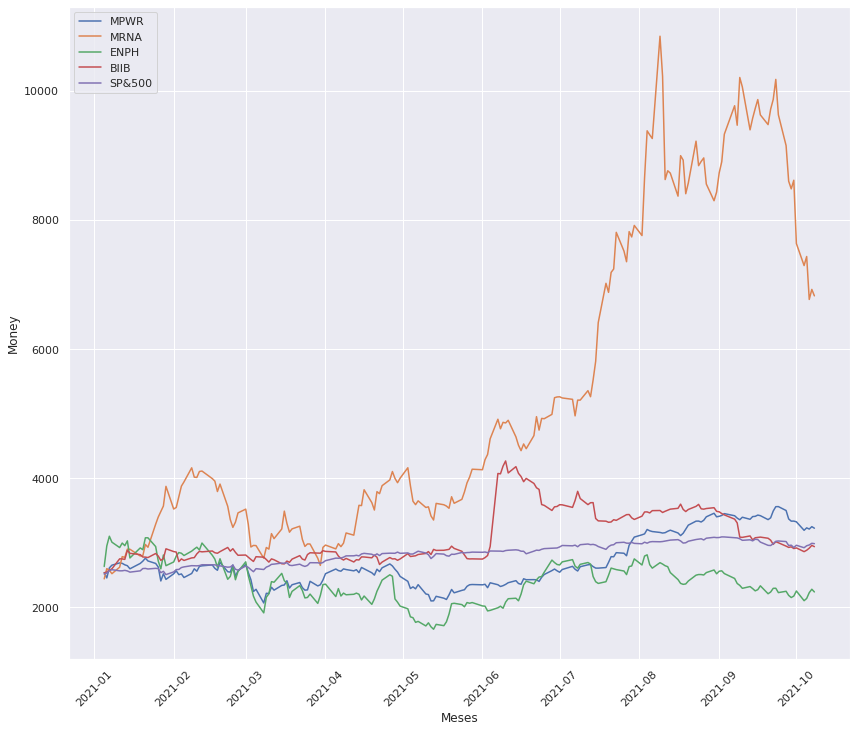

In [162]:
sns.set_theme()

fig, ax = plt.subplots(figsize=(14,12))
plt.plot(Symbol_clustering_tot_transp.columns[0], data=Symbol_clustering_tot_transp, label=Symbol_clustering_tot_transp.columns[0])
plt.plot(Symbol_clustering_tot_transp.columns[1], data=Symbol_clustering_tot_transp, label=Symbol_clustering_tot_transp.columns[1])
plt.plot(Symbol_clustering_tot_transp.columns[2], data=Symbol_clustering_tot_transp, label=Symbol_clustering_tot_transp.columns[2])
plt.plot(Symbol_clustering_tot_transp.columns[3], data=Symbol_clustering_tot_transp, label=Symbol_clustering_tot_transp.columns[3])
plt.plot(Symbol_clustering_tot_transp.columns[4], data=Symbol_clustering_tot_transp, label=Symbol_clustering_tot_transp.columns[4])

#Se colocan los nombres de los ejes x e y
plt.xlabel("Meses", fontdict=None, labelpad=None)
plt.ylabel("Money", fontdict=None, labelpad=None)

#Se rotan los valores del eje x en 45 grados para obtener una mayor visibilidad
plt.xticks(rotation=45)
plt.legend()
plt.show()

#### Cálculo del Sharpe Ratio

In [163]:
# Vuelvo a obtener el valor de los Symbol
Symbol_clustering_tot_iloc['Symbol'] = Symbol_clustering_tot['Symbol']

# Seteo los index con los valores de los Symbol
Symbol_clustering_tot_iloc.set_index('Symbol', inplace=True)

# Hago el transpose del dataframe para facilitar el gráfico
Symbol_clustering_tot_transp = Symbol_clustering_tot_iloc.T

# Imprimo el dataframe transpuesto
Symbol_clustering_tot_transp

Symbol,MPWR,MRNA,ENPH,BIIB,SP&500
2021-01-05,0.015734,-0.022823,0.053646,0.014159,0.006887
2021-01-06,-0.032275,0.064847,0.120675,0.005520,0.005979
2021-01-07,0.063162,-0.010064,0.051037,0.010858,0.014857
2021-01-08,0.016157,-0.020332,-0.029706,0.008385,0.005698
2021-01-11,0.013035,0.040000,-0.027626,0.059317,-0.006741
...,...,...,...,...,...
2021-10-04,-0.039476,-0.044710,-0.066491,-0.019793,-0.012896
2021-10-05,0.011853,0.019243,0.016410,0.007617,0.010405
2021-10-06,-0.005729,-0.089398,0.041856,0.011090,0.004156
2021-10-07,0.011525,0.022948,0.023766,0.014883,0.008646


In [164]:
Symbol_clustering_tot_transp.describe()

Symbol,MPWR,MRNA,ENPH,BIIB,SP&500
count,193.000000,193.000000,193.000000,193.000000,193.000000
mean,0.001647,0.006323,0.000294,0.001315,0.000956
std,0.025421,0.047274,0.041504,0.033170,0.008018
min,-0.092698,-0.156384,-0.141379,-0.067886,-0.024440
25%,-0.011821,-0.022823,-0.022781,-0.011365,-0.003415
50%,0.001292,0.006108,0.000695,-0.000592,0.001244
75%,0.017615,0.035175,0.025407,0.010131,0.005979
max,0.072207,0.171009,0.126003,0.383414,0.024240


In [165]:
std = []
mean = []

# Calculo de desviación y media del cluster 0 
std_0 = Symbol_clustering_tot_transp.iloc[:, 0].std()
mean_0=Symbol_clustering_tot_transp.iloc[:, 0].mean()
sharpe_ratio_0=(mean_0-0)/std_0
std.append(std_0)
mean.append(mean_0)

# Calculo de desviación y media del cluster 1
std_1 = Symbol_clustering_tot_transp.iloc[:, 1].std()
mean_1=Symbol_clustering_tot_transp.iloc[:, 1].mean()
sharpe_ratio_1=(mean_1-0)/std_1
std.append(std_1)
mean.append(mean_1)

# Calculo de desviación y media del cluster 2 
std_2 =Symbol_clustering_tot_transp.iloc[:, 2].std()
mean_2=Symbol_clustering_tot_transp.iloc[:, 2].mean()
sharpe_ratio_2=(mean_2-0)/std_2
std.append(std_2)
mean.append(mean_2)

# Calculo de desviación y media del cluster 3 
std_3 =Symbol_clustering_tot_transp.iloc[:, 3].std()
mean_3=Symbol_clustering_tot_transp.iloc[:, 3].mean()
sharpe_ratio_3=(mean_3-0)/std_3
std.append(std_3)
mean.append(mean_3)

# Calculo de desviación y media del SP&500
std_4 =Symbol_clustering_tot_transp.iloc[:, 4].std()
mean_4=Symbol_clustering_tot_transp.iloc[:, 4].mean()
sharpe_ratio_4=(mean_4-0)/std_4
std.append(std_4)
mean.append(mean_4)

print(std)
print(mean)


[0.025420622198166258, 0.04727387288857728, 0.04150351145174742, 0.03316972845434791, 0.00801760689668654]
[0.0016470907780022873, 0.0063228599168673166, 0.00029442028500327276, 0.0013152736333702922, 0.0009557980332136957]


In [166]:
tickers = Symbol_clustering_tot_transp.columns
tickers

Index(['MPWR', 'MRNA', 'ENPH', 'BIIB', 'SP&500'], dtype='object', name='Symbol')

In [167]:
fig = px.scatter(tickers, x=std, y=mean, color=tickers, #size=exceso_retorno_list,
                labels={
                     "color": "Ticker",
                     "x": "Media",
                     "y": "Volatilidad",
                    "size":"Sharpe Ratio"
                 },
                title='Sharpe Radio')
fig.show()

## Agregado Opcional

Si disponemos de más tiempo, podemos intentar elegir nuestras acciones desde los clusters de manera más inteligente. Por ejemplo, en vez de hacerlo de manera aleatoria, podemos elegir la que tenga la menor volatilidad, o la que tenga el mejor rendimiento predecible según algún indicador técnico o modelo que hayamos podido entrenar en los prácticos 3 y 4.

También podemos hacer que la estrategia cambie de acciones por día o mes de acuerdo al criterio que se elija. Graficar nuevamente estas estrategias y compararlas con el índice.